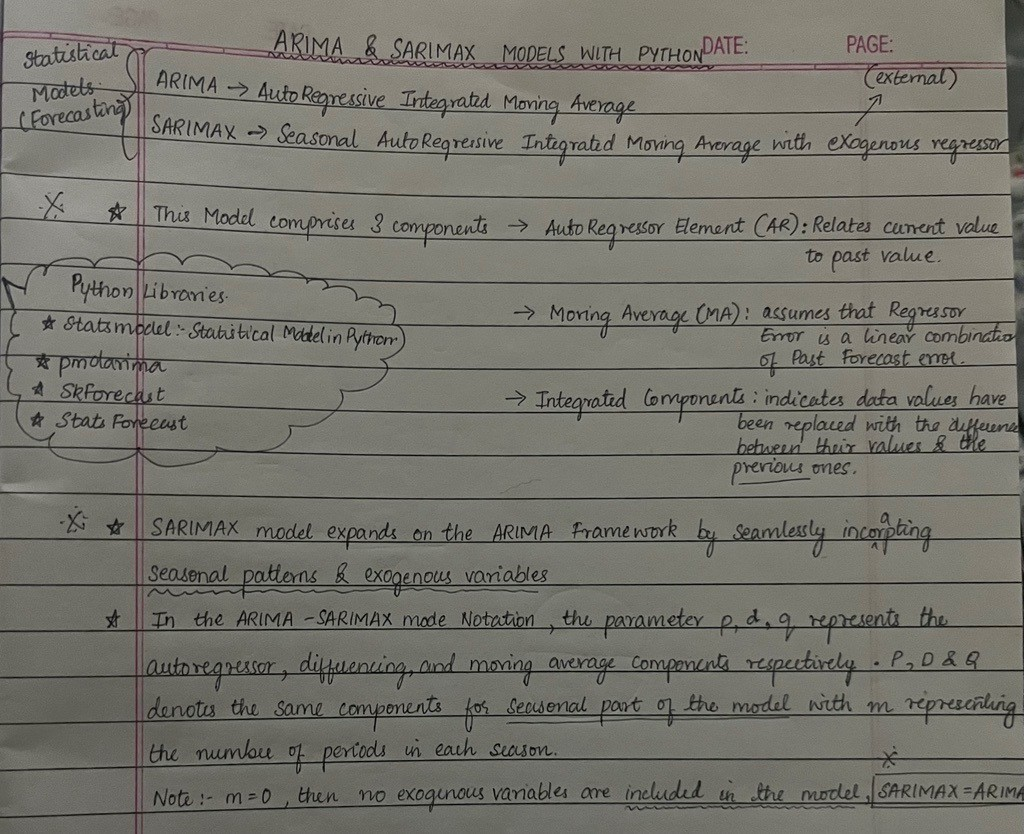

In [16]:
# Libraries
# ======================================================================================
import numpy as np
import pandas as pd
from io import StringIO
import contextlib
import re
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')

# pmdarima
from pmdarima import ARIMA
from pmdarima import auto_arima

# statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

# skforecast
from skforecast.Sarimax import Sarimax
from skforecast.ForecasterSarimax import ForecasterSarimax
from skforecast.model_selection_sarimax import backtesting_sarimax
from skforecast.model_selection_sarimax import grid_search_sarimax
from sklearn.metrics import mean_absolute_error

import warnings

In [17]:
# Download data
# ======================================================================================

url = (
    'https://raw.githubusercontent.com/JoaquinAmatRodrigo/Estadistica-machine-learning-python/'
    'master/data/consumos-combustibles-mensual.csv'
)
data = pd.read_csv(url, sep=',')
data = data[['Fecha', 'Gasolinas']]
data.head()

,Fecha,Gasolinas
0,1969-01-01,166875.2129
1,1969-02-01,155466.8105
2,1969-03-01,184983.6699
3,1969-04-01,202319.8164
4,1969-05-01,206259.1523


In [18]:
data = data.rename(columns={'Fecha':'date', 'Gasolinas':'litters'})
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')

In [19]:
data = data.set_index('date')
data = data.loc[:'1990-01-01 00:00:00']
data = data.asfreq('MS')
data = data['litters']
display(data.head(4))

date
1969-01-01    166875.2129
1969-02-01    155466.8105
1969-03-01    184983.6699
1969-04-01    202319.8164
Freq: MS, Name: litters, dtype: float64

In [20]:
# Train-test dates
# ======================================================================================
end_train = '1980-01-01 23:59:59'
print(f"Train dates : {data.index.min()} --- {data.loc[:end_train].index.max()}  (n={len(data.loc[:end_train])})")
print(f"Test dates  : {data.loc[end_train:].index.min()} --- {data.loc[:].index.max()}  (n={len(data.loc[end_train:])})")
data_train = data.loc[:end_train]
data_test  = data.loc[end_train:]

Train dates : 1969-01-01 00:00:00 --- 1980-01-01 00:00:00  (n=133)
Test dates  : 1980-02-01 00:00:00 --- 1990-01-01 00:00:00  (n=120)


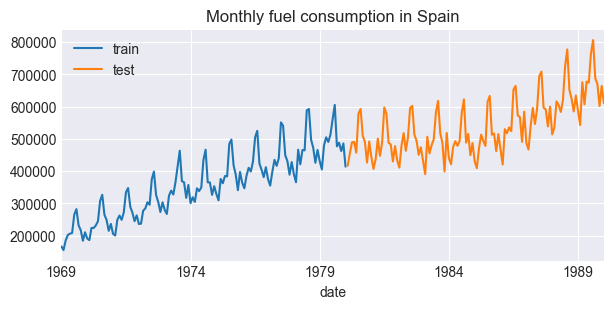

In [22]:
# Plot
# ======================================================================================
fig, ax=plt.subplots(figsize=(7, 3))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
ax.set_title('Monthly fuel consumption in Spain')
ax.legend()

# Exploratory Analysis: Stationarity and Differentiation

Before fitting an ARIMA model to time series data, it is important to conduct an exploratory analysis to determine, at least, the following:
1. Stationarity: Stationarity means that the statistical properties (mean, variance...) remain constant over time, so time series with trends or seasonality are not stationary. Since ARIMA assumes the stationarity of the data, it is essential to subject the data to rigorous tests, such as the Augmented Dickey-Fuller test, to assess stationarity. If non-stationarity is found, the series should be differenced until stationarity is achieved. This analysis helps to determine the optimal value of the parameter  d.
2. Autocorrelation analysis: Plot the autocorrelation and partial autocorrelation functions (ACF and PACF) to identify potential lag relationships between data points. This visual analysis provides insight into determining appropriate autoregressive (AR) and moving average (MA) terms ( p and  q) for the ARIMA model.
3. Seasonal decomposition: In cases where seasonality is suspected, decomposing the series into trend, seasonal, and residual components using techniques such as moving averages or seasonal time series decomposition (STL) can reveal hidden patterns and help identify seasonality. This analysis helps to determine the optimal values of the parameters  P,  D,  Q and  m.

# Stationarity
There are several methods to assess whether a given time series is stationary or non-stationary:

1. Visual inspection of the time series: By visually inspecting the time series plot, it becomes possible to identify the presence of a noticeable trend or seasonality. If such patterns are apparent, it is probable that the series is non-stationary.
2. Summary statistics: Calculate summary statistics, such as the mean and variance, for various segments of the series. If significant differences exist, the series is not stationary.
3. Statistical tests: Apply statistical tests such as the Augmented Dickey-Fuller test or the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test.

**1. Visual Inspection**
Plot shows a clear positive trend in the series, indicating a steady increase over time. Consequently, the mean of the series increases over time, confirming its non-stationarity.

**2. Summary Statistics**

Differencing is one of the easiest techniques to detrend a time series. A new series is generated where the value at the current time step is calculated as the difference between the original observation and the observation at the previous time step, i.e. the difference between consecutive values. Mathematically, the first difference is calculated as:

ΔXt=Xt−Xt−1

Where  Xt is the value at time  t and  Xt−1 is the value at time  t−1. 

**3.Seasonal decomposition**

**Augmented Dickey-Fuller test**

The Augmented Dickey-Fuller test takes as its null hypothesis that the time series has a unit root - a characteristic of non-stationary time series. Conversely, the alternative hypothesis (under which the null hypothesis is rejected) is that the series is stationary.

Null Hypothesis (HO): The series is not stationary or has a unit root.

Alternative hypothesis (HA): The series is stationary with no unit root.

Since the null hypothesis assumes the presence of a unit root, the p-value obtained should be less than a specified significance level, often set at 0.05, to reject this hypothesis. This result indicates the stationarity of the series. The adfuller() function within the Statsmodels library is a handy tool for implementing the ADF test. Its output includes four values: the p-value, the value of the test statistic, the number of lags included in the test, and critical value thresholds for three different levels of significance.


**Kwiatkowski-Phillips-Schmidt-Shin test (KPSS)**

The KPSS test checks if a time series is stationary around a mean or linear trend. In this test, the null hypothesis is that the data are stationary, and we look for evidence that the null hypothesis is false. Consequently, small p-values (e.g., less than 0.05) rejects the null hypothesis and suggest that differencing is required. Statsmodels library provides an implementation of the KPSS test via the kpss() function.

In [24]:
data_diff_1 = data_train.diff().dropna()
data_diff_1

date
1969-02-01    -11408.4024
1969-03-01     29516.8594
1969-04-01     17336.1465
1969-05-01      3939.3359
1969-06-01      2152.6856
                 ...     
1979-09-01   -128395.4980
1979-10-01     11202.5058
1979-11-01    -25740.6347
1979-12-01     23507.4902
1980-01-01    -71760.6159
Freq: MS, Name: litters, Length: 132, dtype: float64

In [26]:
data_diff_2 = data_diff_1.diff().dropna()
data_diff_2

date
1969-03-01     40925.2618
1969-04-01    -12180.7129
1969-05-01    -13396.8106
1969-06-01     -1786.6503
1969-07-01     55172.1972
                 ...     
1979-09-01   -173162.6386
1979-10-01    139598.0038
1979-11-01    -36943.1405
1979-12-01     49248.1249
1980-01-01    -95268.1061
Freq: MS, Name: litters, Length: 131, dtype: float64

In [28]:
print('Test stationarity for original series')
print('-------------------------------------')
adfuller_result = adfuller(data)
kpss_result = kpss(data)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

print('\nTest stationarity for differenced series (order=1)')
print('--------------------------------------------------')
adfuller_result = adfuller(data_diff_1)
kpss_result = kpss(data.diff().dropna())
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

print('\nTest stationarity for differenced series (order=2)')
print('--------------------------------------------------')
adfuller_result = adfuller(data_diff_2)
kpss_result = kpss(data.diff().diff().dropna())
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

Test stationarity for original series
-------------------------------------
ADF Statistic: -0.4461298099822765, p-value: 0.9021071923942672
KPSS Statistic: 2.2096370946978383, p-value: 0.01

Test stationarity for differenced series (order=1)
--------------------------------------------------
ADF Statistic: -3.6417276900323126, p-value: 0.005011605002137415
KPSS Statistic: 0.3132711623572787, p-value: 0.1

Test stationarity for differenced series (order=2)
--------------------------------------------------
ADF Statistic: -8.233942641655913, p-value: 5.959599575499182e-13
KPSS Statistic: 0.08065668267482227, p-value: 0.1


C:\Users\ronaldo.f-v\AppData\Local\Temp\ipykernel_23460\739381794.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(data)
C:\Users\ronaldo.f-v\AppData\Local\Temp\ipykernel_23460\739381794.py:11: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(data.diff().dropna())
C:\Users\ronaldo.f-v\AppData\Local\Temp\ipykernel_23460\739381794.py:18: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(data.diff().diff().dropna())


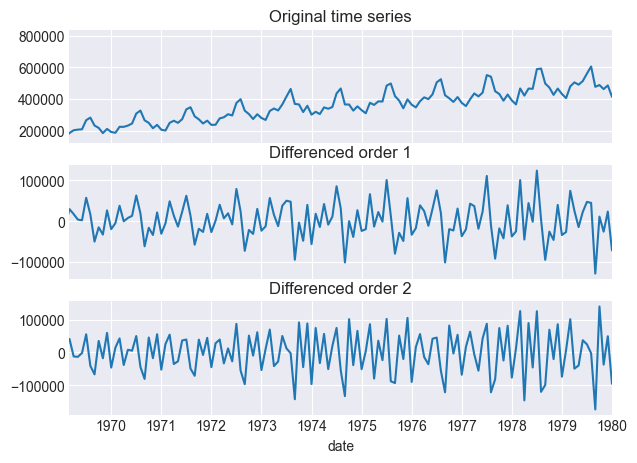

In [29]:
# Plot series
# ==============================================================================
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(7, 5), sharex=True)
data.plot(ax=axs[0], title='Original time series')
data_diff_1.plot(ax=axs[1], title='Differenced order 1')
data_diff_2.plot(ax=axs[2], title='Differenced order 2');

After checking the first and second-order differences, the p-value indicates a statistically significant decrease below the widely-recognized and accepted threshold of 0.05 for order=1. Therefore, the most appropriate selection for the ARIMA parameter  d
  is 1.

# Autocorrelation Analysis

VERY IMPORTANT:
Plotting the autocorrelation function (ACF) and partial autocorrelation function (PACF) of the time series can provide insight into the appropriate values for  p and  q. The ACF helps in identifying the value of  q(lag in the moving average part), while the PACF assists in identifying the value of  p (lag in the autoregressive part).

**Autocorrelation Function (ACF)**

The ACF calculates the correlation between a time series and its lagged values. Within the context of ARIMA modeling, a sharp drop-off in the ACF after a few lags indicates that the data have a finite autoregressive order. The lag at which the ACF drops off provides an estimation of the value of  q. If the ACF displays a sinusoidal or damped sinusoidal pattern, it suggests seasonality is present and requires consideration of seasonal orders in addition to non-seasonal orders.

**Partial Autocorrelation Function (PACF)**

The PACF measures the correlation between a lagged value and the current value of the time series, while accounting for the effect of the intermediate lags. In the context of ARIMA modeling, if the PACF sharply cuts off after a certain lag, while the remaining values are within the confidence interval, it suggests an AR model of that order. The lag, at which the PACF cuts off, gives an idea of the value of  p.

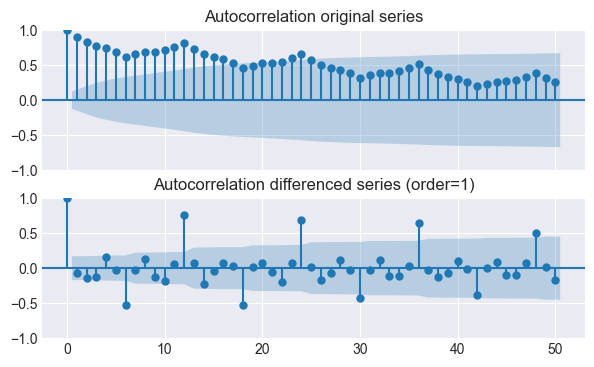

In [30]:
# Autocorrelation plot for original and differenced series
# ==============================================================================
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(7, 4), sharex=True)
plot_acf(data, ax=axs[0], lags=50, alpha=0.05)
axs[0].set_title('Autocorrelation original series')
plot_acf(data_diff_1, ax=axs[1], lags=50, alpha=0.05)
axs[1].set_title('Autocorrelation differenced series (order=1)');

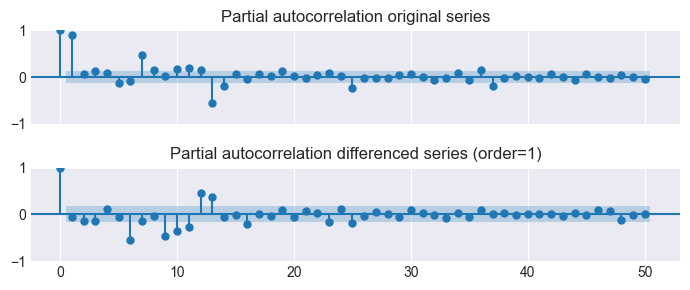

In [31]:
# Partial autocorrelation plot for original and differenced series
# ==============================================================================
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(7, 3), sharex=True)
plot_pacf(data, ax=axs[0], lags=50, alpha=0.05)
axs[0].set_title('Partial autocorrelation original series')
plot_pacf(data_diff_1, ax=axs[1], lags=50, alpha=0.05)
axs[1].set_title('Partial autocorrelation differenced series (order=1)');
plt.tight_layout();

Based on the autocorrelation function, the optimal value for parameter  p is 0. However, we will assign a value of 1 to provide an autoregressive component to the model. Regarding the  q component, the partial autocorrelation function suggests a value of 1.

# Time seasonaltiy descomposition
Time series decomposition involves breaking down the original time series into its underlying components, namely trend, seasonality, and residual (error) components. The decomposition can be either additive or multiplicative. Including time series decomposition along with ACF and PACF analysis provides a comprehensive approach to understanding the underlying structure of the data and choose appropriate ARIMA parameters.

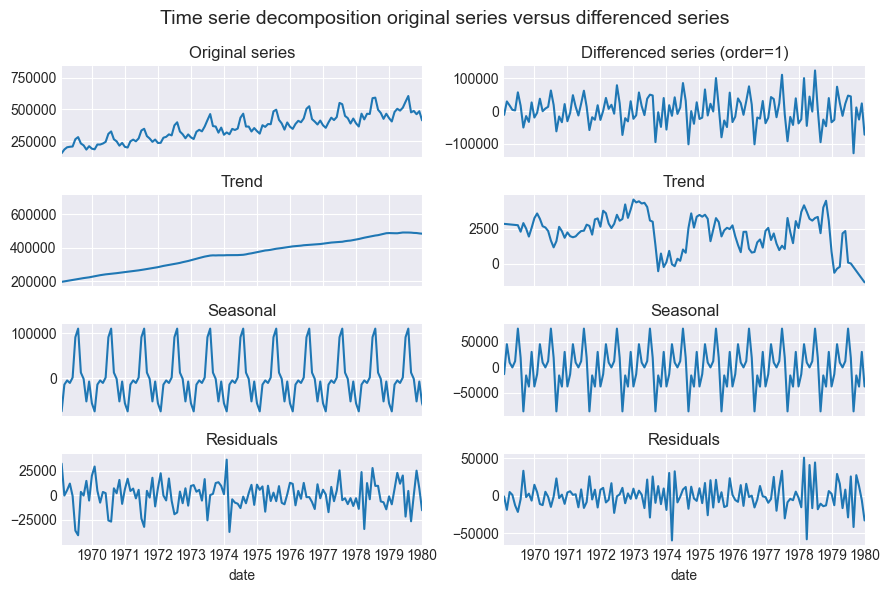

In [33]:
# Time series decomposition of original versus differenced series
# ==============================================================================
res_decompose = seasonal_decompose(data, model='additive', extrapolate_trend='freq')
res_descompose_diff_2 = seasonal_decompose(data_diff_1, model='additive', extrapolate_trend='freq')

fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(9, 6), sharex=True)

res_decompose.observed.plot(ax=axs[0, 0])
axs[0, 0].set_title('Original series')
res_decompose.trend.plot(ax=axs[1, 0])
axs[1, 0].set_title('Trend')
res_decompose.seasonal.plot(ax=axs[2, 0])
axs[2, 0].set_title('Seasonal')
res_decompose.resid.plot(ax=axs[3, 0])
axs[3, 0].set_title('Residuals')
res_descompose_diff_2.observed.plot(ax=axs[0, 1])
axs[0, 1].set_title('Differenced series (order=1)')
res_descompose_diff_2.trend.plot(ax=axs[1, 1])
axs[1, 1].set_title('Trend')
res_descompose_diff_2.seasonal.plot(ax=axs[2, 1])
axs[2, 1].set_title('Seasonal')
res_descompose_diff_2.resid.plot(ax=axs[3, 1])
axs[3, 1].set_title('Residuals')
fig.suptitle('Time serie decomposition original series versus differenced series', fontsize=14)
fig.tight_layout();

The recurring pattern every 12 months suggests an annual seasonality, likely influenced by holiday factors. 

# Conclusions
Based on the results of the exploratory analysis, utilizing a combination of first-order differencing and seasonal differencing may be the most appropriate approach. First-order differencing is effective in capturing transitions between observations and highlighting short-term fluctuations. Concurrently, seasonal differencing, which covers a period of 12 months and represents the shift from one year to the next, effectively captures the inherent cyclic patterns in the data. This approach allows us to achieve the necessary stationarity for the following ARIMA modeling process.

In [35]:
# First order differentiation combined with seasonal differentiation
# ==============================================================================
data_diff_1_12 = data_train.diff().diff(12).dropna()

warnings.filterwarnings("ignore")
adfuller_result = adfuller(data_diff_1_12)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
kpss_result = kpss(data_diff_1_12)
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')
warnings.filterwarnings("default")

ADF Statistic: -4.387457230769959, p-value: 0.0003123773271126894
KPSS Statistic: 0.06291573421251054, p-value: 0.1


# ARIMA-SARIMAX model

In [36]:
# ARIMA model with statsmodels.Sarimax
# ==============================================================================
warnings.filterwarnings("ignore", category=UserWarning, message='Non-invertible|Non-stationary')
model = SARIMAX(endog = data_train, order = (1, 1, 1), seasonal_order = (1, 1, 1, 12))
model_res = model.fit(disp=0)
warnings.filterwarnings("default")

model_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                            litters   No. Observations:                  133
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1356.051
Date:                            Tue, 26 Sep 2023   AIC                           2722.103
Time:                                    22:52:03   BIC                           2736.040
Sample:                                01-01-1969   HQIC                          2727.763
                                     - 01-01-1980                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4972      0.134     -3.707      0.000      -0.760      -0.234
ma.L1         -0.0096      0.146     -0.066      0.947      -0.295       0.276
ar.S.L12       0.0465      0.162      0.288      0.774      -0.270       0.364
ma.S.L12      -0.3740      0.203     -1.847      0.065      -0.771       0.023
sigma2      3.291e+08   1.06e-09    3.1e+17      0.000    3.29e+08    3.29e+08
===================================================================================
Ljung-Box (L1) (Q):                   5.13   Jarque-Bera (JB):                18.12
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               1.26   Skew:                            -0.42
Prob(H) (two-sided):                  0.46   Kurtosis:                         4.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.74e+32. Standard errors may be unstable.
"""

**INFORMATION**

Model Fit Statistics: This part includes several statistics that help you evaluate how well the model fits the data:

Log-Likelihood: A measure of how well the model explains the observed data. When fitting an ARIMA model, negative log-likelihood values will be encounter, with more negative values indicating a poorer fit to the data, and values closer to zero indicating a better fit.

AIC (Akaike Information Criterion): A goodness-of-fit metric that balances the fit of the model with its complexity. Lower AIC values are preferred.

BIC (Bayesian Information Criterion): Similar to AIC, but penalizes model complexity more. As with AIC, lower BIC values are better.

HQIC (Hannan-Quinn Information Criterion): Another model selection criterion, similar to AIC and BIC.

In [37]:
# Prediction
# ==============================================================================
predictions_statsmodels = model_res.get_forecast(steps=len(data_test)).predicted_mean
predictions_statsmodels.name = 'predictions_statsmodels'
display(predictions_statsmodels.head(4))

1980-02-01    407504.056921
1980-03-01    473997.245801
1980-04-01    489983.091488
1980-05-01    485517.462856
Freq: MS, Name: predictions_statsmodels, dtype: float64

# Skforecast 

In [38]:
# ARIMA model with skforecast.Sarimax
# ==============================================================================
warnings.filterwarnings("ignore", category=UserWarning, message='Non-invertible|Non-stationary')

model = Sarimax(order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
model.fit(y=data_train)
model.summary()

warnings.filterwarnings("default")

In [39]:
# Prediction
# ==============================================================================
predictions_skforecast = model.predict(steps=len(data_test))
predictions_skforecast.columns = ['skforecast']
display(predictions_skforecast.head(4))

,skforecast
1980-02-01,407504.056921
1980-03-01,473997.245801
1980-04-01,489983.091488
1980-05-01,485517.462856


# pdmarima

In [41]:
# ARIMA model with pdmarima.Sarimax
# ==============================================================================
model = ARIMA(order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
model.fit(y=data_train)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  133
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1355.749
Date:                            Tue, 26 Sep 2023   AIC                           2723.498
Time:                                    23:05:36   BIC                           2740.223
Sample:                                01-01-1969   HQIC                          2730.290
                                     - 01-01-1980                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   -474.5820   1101.722     -0.431      0.667   -2633.917    1684.753
ar.L1         -0.4896      0.138     -3.554      0.000      -0.760      -0.220
ma.L1         -0.0211      0.151     -0.139      0.889      -0.317       0.275
ar.S.L12       0.0545      0.164      0.331      0.740      -0.268       0.377
ma.S.L12      -0.3841      0.204     -1.884      0.060      -0.784       0.015
sigma2      3.289e+08      0.002   1.84e+11      0.000    3.29e+08    3.29e+08
===================================================================================
Ljung-Box (L1) (Q):                   4.90   Jarque-Bera (JB):                18.55
Prob(Q):                              0.03   Prob(JB):                         0.00
Heteroskedasticity (H):               1.27   Skew:                            -0.43
Prob(H) (two-sided):                  0.46   Kurtosis:                         4.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.32e+27. Standard errors may be unstable.
"""

In [42]:
# Prediction
# ==============================================================================
predictions_pdmarima = model.predict(len(data_test))
predictions_pdmarima.name = 'predictions_pdmarima'
display(predictions_pdmarima.head(4))

1980-02-01    406998.311391
1980-03-01    472944.444462
1980-04-01    488389.125312
1980-05-01    483432.075680
Freq: MS, Name: predictions_pdmarima, dtype: float64

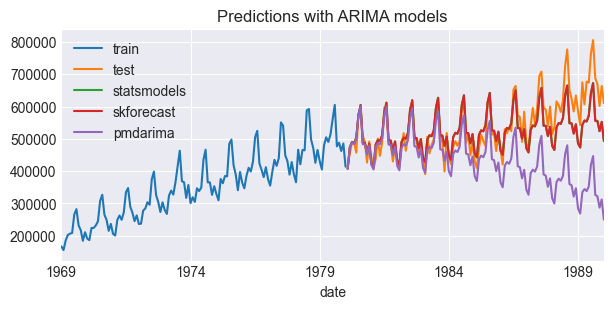

In [47]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
predictions_statsmodels.plot(ax=ax, label='statsmodels')
predictions_skforecast.plot(ax=ax, label='skforecast')
predictions_pdmarima.plot(ax=ax, label='pmdarima')
ax.set_title('Predictions with ARIMA models')
ax.legend();

#Note : Since skforecast Sarimax, is a wrapper of statsmodels SARIMAX, the results are the same.

# ForecasterSarimax

The ForecasterSarimax class allows training and validation of ARIMA and SARIMAX models using the skforecast API. ForecasterSarimax is compatible with two ARIMA-SARIMAX implementations:

In [48]:
#Train - Predict
# ARIMA model with ForecasterSarimax and skforecast Sarimax
# ==============================================================================
forecaster = ForecasterSarimax(
                 regressor=Sarimax(order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
             )
forecaster.fit(y=data_train, suppress_warnings=True)

# Prediction
predictions = forecaster.predict(steps=len(data_test))
predictions.head(4)

1980-02-01    407504.056921
1980-03-01    473997.245801
1980-04-01    489983.091488
1980-05-01    485517.462856
Freq: MS, Name: pred, dtype: float64

# Back-testing: 
Refer the link: https://skforecast.org/0.10.1/user_guides/backtesting.html

The following example shows the application of backtesting in assessing the performance of the SARIMAX model when generating forecasts for the upcoming 12 months on an annual schedule. In this context, a forecast is generated at the end of each December, predicting values for the subsequent 12 months.

In [49]:
# Backtest forecaster
# ==============================================================================
forecaster = ForecasterSarimax(
                 regressor=Sarimax(
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                maxiter=200
                            )
             )

metric, predictions = backtesting_sarimax(
                          forecaster            = forecaster,
                          y                     = data,
                          initial_train_size    = len(data_train),
                          fixed_train_size      = False,
                          steps                 = 12,
                          metric                = 'mean_absolute_error',
                          refit                 = True,
                          n_jobs                = "auto",
                          suppress_warnings_fit = True,
                          verbose               = True,
                          show_progress         = True
                      )

print(f"Metric (mean_absolute_error): {metric}")
display(predictions.head(4))

Information of backtesting process
----------------------------------
Number of observations used for initial training: 133
Number of observations used for backtesting: 120
    Number of folds: 10
    Number of steps per fold: 12
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   1969-01-01 00:00:00 -- 1980-01-01 00:00:00  (n=133)
    Validation: 1980-02-01 00:00:00 -- 1981-01-01 00:00:00  (n=12)
Fold: 1
    Training:   1969-01-01 00:00:00 -- 1981-01-01 00:00:00  (n=145)
    Validation: 1981-02-01 00:00:00 -- 1982-01-01 00:00:00  (n=12)
Fold: 2
    Training:   1969-01-01 00:00:00 -- 1982-01-01 00:00:00  (n=157)
    Validation: 1982-02-01 00:00:00 -- 1983-01-01 00:00:00  (n=12)
Fold: 3
    Training:   1969-01-01 00:00:00 -- 1983-01-01 00:00:00  (n=169)
    Validation: 1983-02-01 00:00:00 -- 1984-01-01 00:00:00  (n=12)
Fold: 4
    Training:   1969-01-01 00:00:00 -- 1984-01-01 00:00:00  (n=181)
    Validation: 1984-02-01 00:00:00 --

100%|██████████| 10/10 [00:03<00:00,  2.58it/s]

Metric (mean_absolute_error): 19611.236346784568


,pred
1980-02-01,407504.056921
1980-03-01,473997.245801
1980-04-01,489983.091488
1980-05-01,485517.462856


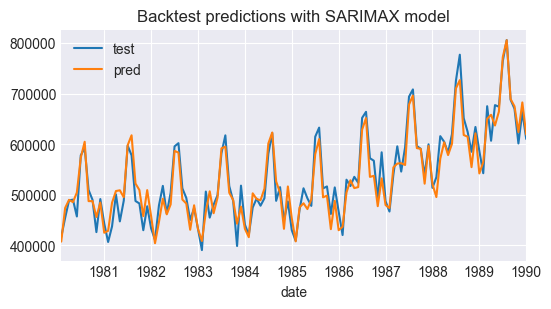

In [50]:
# Plot backtest predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
data.loc[end_train:].plot(ax=ax, label='test')
predictions.plot(ax=ax)
ax.set_title('Backtest predictions with SARIMAX model')
ax.legend();

# Model tuning
The exploratory analysis has successfully narrowed down the search space for the optimal hyperparameters of the model. However, to definitively determine the most appropriate values, the use of strategic search methods is essential. Among these methods, two widely used approaches are:

Statistical Criteria: Information criterion metrics, such as Akaike's Information Criterion (AIC) or Bayesian Information Criterion (BIC), use different penalties on the maximum likelihood (log-likelihood) estimate of the model as a measure of fit. The advantage of using such criteria is that they are computed only on the training data, eliminating the need for predictions on new data. As a result, the optimization process is greatly accelerated. The well-known Auto Arima algorithm uses this approach.

Validation Techniques: The use of validation techniques, especially backtesting, is another effective strategy. Backtesting involves evaluating the performance of the model using historical data to simulate real-world conditions. This helps to validate the effectiveness of the hyperparameters under different scenarios, providing a practical assessment of their viability.

Train dates      : 1969-01-01 00:00:00 --- 1976-01-01 00:00:00  (n=85)
Validation dates : 1976-02-01 00:00:00 --- 1984-01-01 00:00:00  (n=96)
Test dates       : 1984-02-01 00:00:00 --- 1990-01-01 00:00:00  (n=72)


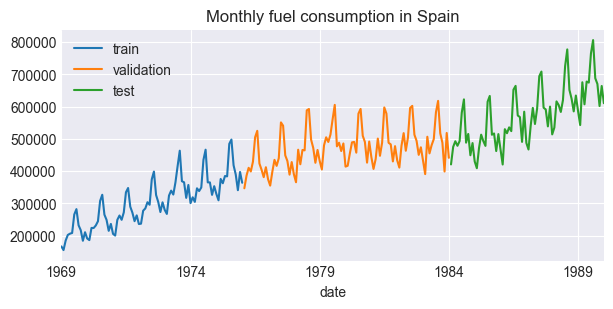

In [52]:
#NOTE: It is crucial to conduct hyperparameter optimization using a validation dataset, rather than the test dataset, to ensure a accurate evaluation of model performance
# Train-validation-test data
# ======================================================================================
end_train = '1976-01-01 23:59:59'
end_val = '1984-01-01 23:59:59'
print(
    f"Train dates      : {data.index.min()} --- {data.loc[:end_train].index.max()}  "
    f"(n={len(data.loc[:end_train])})"
)
print(
    f"Validation dates : {data.loc[end_train:].index.min()} --- {data.loc[:end_val].index.max()}  "
    f"(n={len(data.loc[end_train:end_val])})"
)
print(
    f"Test dates       : {data.loc[end_val:].index.min()} --- {data.index.max()}  "
    f"(n={len(data.loc[end_val:])})"
)

# Plot
# ======================================================================================
fig, ax = plt.subplots(figsize=(7, 3))
data.loc[:end_train].plot(ax=ax, label='train')
data.loc[end_train:end_val].plot(ax=ax, label='validation')
data.loc[end_val:].plot(ax=ax, label='test')
ax.set_title('Monthly fuel consumption in Spain')
ax.legend();

In [53]:
# Grid search based on backtesting
# ==============================================================================
forecaster = ForecasterSarimax(
                 regressor=Sarimax(order=(1, 1, 1), maxiter=500), # Placeholder replaced in the grid search
             )

param_grid = {
    'order': [(0, 1, 0), (0, 1, 1), (1, 1, 0), (1, 1, 1), (2, 1, 1)],
    'seasonal_order': [(0, 0, 0, 0), (0, 1, 0, 12), (1, 1, 1, 12)],
    'trend': [None, 'n', 'c']
}

results_grid = grid_search_sarimax(
                   forecaster            = forecaster,
                   y                     = data.loc[:end_val],
                   param_grid            = param_grid,
                   steps                 = 12,
                   refit                 = True,
                   metric                = 'mean_absolute_error',
                   initial_train_size    = len(data_train),
                   fixed_train_size      = False,
                   return_best           = False,
                   n_jobs                = 'auto',
                   suppress_warnings_fit = True,
                   verbose               = False,
                   show_progress         = True
               )

results_grid.head(5)

Number of models compared: 45.


params grid: 100%|██████████| 45/45 [00:55<00:00,  1.23s/it]


,params,mean_absolute_error,order,seasonal_order,trend
16,"{'order': (0, 1, 1), 'seasonal_order': (1, 1, ...",18789.897507,"(0, 1, 1)","(1, 1, 1, 12)",n
15,"{'order': (0, 1, 1), 'seasonal_order': (1, 1, ...",18789.897507,"(0, 1, 1)","(1, 1, 1, 12)",None
34,"{'order': (1, 1, 1), 'seasonal_order': (1, 1, ...",19897.376859,"(1, 1, 1)","(1, 1, 1, 12)",n
33,"{'order': (1, 1, 1), 'seasonal_order': (1, 1, ...",19897.376859,"(1, 1, 1)","(1, 1, 1, 12)",None
43,"{'order': (2, 1, 1), 'seasonal_order': (1, 1, ...",20176.737676,"(2, 1, 1)","(1, 1, 1, 12)",n


In [54]:
# Auto arima: selection base on AIC
# ==============================================================================
model = auto_arima(
            y                 = data.loc[:end_val],
            start_p           = 0,
            start_q           = 0,
            max_p             = 3,
            max_q             = 3,
            seasonal          = True,
            test              = 'adf',
            m                 = 12, # Seasonal period
            d                 = None, # The algorithm will determine 'd'
            D                 = None, # The algorithm will determine 'D'
            trace             = True,
            error_action      = 'ignore',
            suppress_warnings = True,
            stepwise          = True
        )

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=3903.204, Time=0.38 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=3942.897, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=3846.786, Time=0.32 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=3840.318, Time=0.38 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=3873.797, Time=0.38 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=3841.882, Time=0.71 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=3841.572, Time=2.06 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=3852.231, Time=0.28 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=3842.593, Time=1.96 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=3904.615, Time=0.12 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=3834.135, Time=0.47 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=3866.187, Time=0.09 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=3835.564, Time=0.35 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=3835.160, Time=1.27 sec
 ARIMA(1,1,1)(1,1,0

In [55]:
# Capture auto_arima trace in a pandas dataframe
# ==============================================================================
buffer = StringIO()
with contextlib.redirect_stdout(buffer):
    auto_arima(
            y                 = data.loc[:end_val],
            start_p           = 0,
            start_q           = 0,
            max_p             = 3,
            max_q             = 3,
            seasonal          = True,
            test              = 'adf',
            m                 = 12, # Seasonal period
            d                 = None, # The algorithm will determine 'd'
            D                 = None, # The algorithm will determine 'D'
            trace             = True,
            error_action      = 'ignore',
            suppress_warnings = True,
            stepwise          = True
        )
trace_autoarima = buffer.getvalue()
pattern = r'ARIMA\((\d+),(\d+),(\d+)\)\((\d+),(\d+),(\d+)\)\[(\d+)\]\s+(intercept)?\s+:\s+AIC=([\d\.]+), Time=([\d\.]+) sec'
matches = re.findall(pattern, trace_autoarima)
results = pd.DataFrame(matches, columns=['p', 'd', 'q', 'P', 'D', 'Q', 'm', 'intercept', 'AIC', 'Time'])
results['order'] = results[['p', 'd', 'q']].apply(lambda x: f"({x[0]},{x[1]},{x[2]})", axis=1)
results['seasonal_order'] = results[['P', 'D', 'Q', 'm']].apply(lambda x: f"({x[0]},{x[1]},{x[2]},{x[3]})", axis=1)
results = results[['order', 'seasonal_order', 'intercept', 'AIC', 'Time']]
results.sort_values(by='AIC').reset_index(drop=True)

,order,seasonal_order,intercept,AIC,Time
0,"(1,1,1)","(0,1,1,12)",,3834.135,0.40
1,"(2,1,0)","(0,1,1,12)",,3834.277,0.45
2,"(0,1,2)","(0,1,1,12)",,3834.320,0.34
3,"(1,1,1)","(0,1,2,12)",,3835.160,1.28
4,"(1,1,1)","(0,1,1,12)",intercept,3835.455,0.46
5,"(1,1,1)","(1,1,1,12)",,3835.564,0.40
6,"(2,1,1)","(0,1,1,12)",,3836.104,1.22
7,"(1,1,2)","(0,1,1,12)",,3836.107,0.54
8,"(1,1,1)","(1,1,2,12)",,3836.443,2.14
9,"(1,1,0)","(0,1,1,12)",,3836.696,0.24


In [56]:
# Backtest predictions with the best model according to grid search
# ==============================================================================
forecaster = ForecasterSarimax(
                 regressor=Sarimax(order=(0, 1, 1), seasonal_order=(1, 1, 1, 12), maxiter=500),
             )

metric_m1, predictions_m1 = backtesting_sarimax(
                                forecaster            = forecaster,
                                y                     = data,
                                initial_train_size    = len(data.loc[:end_val]),
                                steps                 = 12,
                                metric                = 'mean_absolute_error',
                                refit                 = True,
                                n_jobs                = "auto",
                                suppress_warnings_fit = True,
                                verbose               = False,
                                show_progress         = True
                            )

# Backtest predictions with the best model according to auto arima
# ==============================================================================
forecaster = ForecasterSarimax(
                 regressor=Sarimax(order=(1, 1, 1), seasonal_order=(0, 1, 1, 12), maxiter=500),
             )

metric_m2, predictions_m2 = backtesting_sarimax(
                                forecaster            = forecaster,
                                y                     = data,
                                initial_train_size    = len(data.loc[:end_val]),
                                steps                 = 12,
                                metric                = 'mean_absolute_error',
                                refit                 = True,
                                n_jobs                = "auto",
                                suppress_warnings_fit = True,
                                verbose               = False,
                                show_progress         = True
                            )

100%|██████████| 6/6 [00:02<00:00,  2.93it/s]


Metric (mean_absolute_error) for grid search model: 19803.08072882776
Metric (mean_absolute_error) for auto arima model : 20149.35220592327


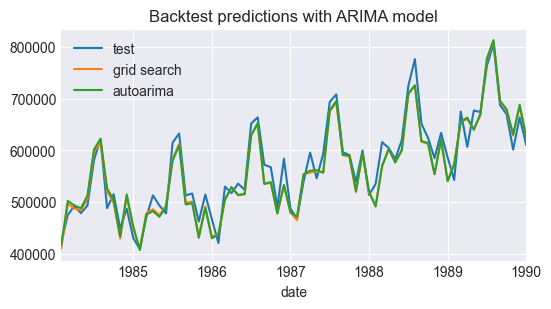

In [58]:
#  Compare predictions
# ==============================================================================
print(f"Metric (mean_absolute_error) for grid search model: {metric_m1}")
print(f"Metric (mean_absolute_error) for auto arima model : {metric_m2}")

fig, ax = plt.subplots(figsize=(6, 3))
data.loc[end_val:].plot(ax=ax, label='test')
predictions_m1 = predictions_m1.rename(columns={'pred': 'grid search'})
predictions_m2 = predictions_m2.rename(columns={'pred': 'autoarima'})
predictions_m1.plot(ax=ax)
predictions_m2.plot(ax=ax)
ax.set_title('Backtest predictions with ARIMA model')
ax.legend();

# Using an already trained ARIMA
Forecasting with an ARIMA model becomes challenging when the forecast horizon data does not immediately follow the last observed value during the training phase. This complexity is due to the moving average (MA) component, which relies on past forecast errors as predictors. Thus, to predict at time  y
 , the error of the  t−1
  prediction becomes a necessity. In situations where this prediction isn't available, the corresponding error remains unavailable. For this reason, in most cases, ARIMA models are retrained each time predictions need to be made.

Despite considerable efforts and advances to speed up the training process for these models, it is not always feasible to retrain the model between predictions, either due to time constraints or insufficient computational resources for repeated access to historical data. An intermediate approach is to feed the model with data from the last training observation to the start of the prediction phase. This technique enables the estimation of intermediate predictions and, as a result, the necessary errors. For example, imagine a situation where a model was trained 20 days ago with daily data from the past three years. When generating new predictions, only the 20 most recent values would be needed, rather than the complete historical dataset (365 * 3 + 20).

Integrating new data into the model can be complex, but the ForecasterSarimax class simplifies this considerably by automating the process through the last_window argument in its predict method.

NOTE: last_window function basically generate additional rows to the data to see the prediction

Train dates       : 1969-01-01 00:00:00 --- 1980-01-01 00:00:00  (n=133)
Last window dates : 1980-02-01 00:00:00 --- 1990-01-01 00:00:00  (n=120)


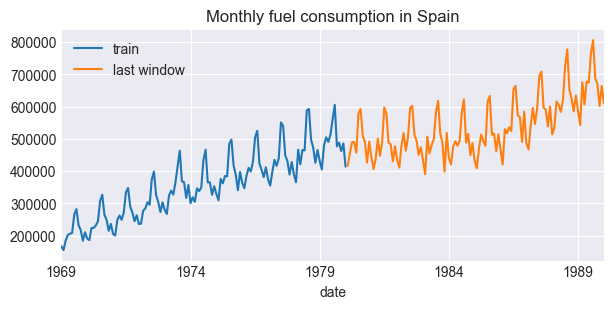

In [73]:
# Split data Train - Last window
# ==============================================================================
end_train = '1980-01-01 23:59:59'
                       
print(
    f"Train dates       : {data.index.min()} --- {data.loc[:end_train].index.max()}  "
    f"(n={len(data.loc[:end_train])})"
)
print(
    f"Last window dates : {data.loc[end_train:].index.min()} --- {data.index.max()}  "
    f"(n={len(data.loc[end_train:])})"
)

# Plot
# ======================================================================================
fig, ax = plt.subplots(figsize=(7, 3))
data.loc[:end_train].plot(ax=ax, label='train')
data.loc[end_train:].plot(ax=ax, label='last window')
ax.set_title('Monthly fuel consumption in Spain')
ax.legend();

The Forecaster is trained using data up until '1980-01-01' and will then utilize the remaining information as the last window of observations to generate new predictions.

In [74]:
# Train ARIMA forecaster with values from 1969-01-01 to 1980-01-01
# ==============================================================================
forecaster = ForecasterSarimax(
                 regressor=Sarimax(order=(0, 1, 1), seasonal_order=(1, 1, 1, 12), maxiter=500),
             )
forecaster.fit(y=data.loc[:end_train])

In [75]:
# Predict using last window
# ==============================================================================
predictions = forecaster.predict(
                  steps       = 12,
                  last_window = data.loc[end_train:]
              )
predictions.head(5)

1990-02-01    580893.320802
1990-03-01    693624.449212
1990-04-01    654315.472034
1990-05-01    688715.300914
1990-06-01    698974.259054
Freq: MS, Name: pred, dtype: float64

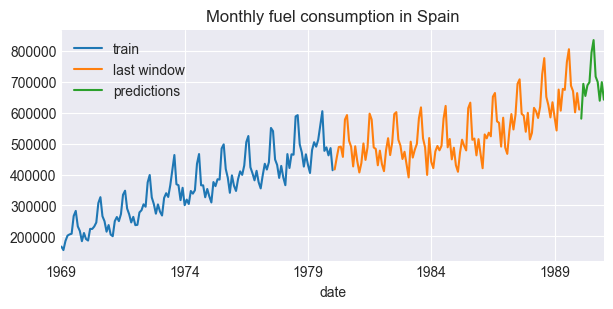

In [76]:
# Plot predictions
# ======================================================================================
fig, ax = plt.subplots(figsize=(7, 3))
data.loc[:end_train].plot(ax=ax, label='train')
data.loc[end_train:].plot(ax=ax, label='last window')
predictions.plot(ax=ax, label='predictions')
ax.set_title('Monthly fuel consumption in Spain')
ax.legend();

# Thank You!!